<a href="https://colab.research.google.com/github/entc-17-fyp-20/WPF_Data_Visualization/blob/Kusal/GRU_RNN_model_for_short_term_power_forecasting_Tested_with_new_CEB_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image
%matplotlib inline
import plotly.express as px
import io


pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

url1 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/S6%2010%20seconed%20data.csv' #S6 10 seconed data.csv
url2 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/AE59_1.csv' #AE59_1
url3 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/AE59_2.csv' #AE59_2
url4 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V08%20June%2010%20sec%20data.csv' #V08 June 10 sec data.csv; does not contain current columns
url5 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V13%20June%2010%20sec%20data.csv' #V13 June 10 sec data.csv
url6 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V08%20July%2010%20sec%20data.csv' #V08 July 10 sec data.csv
url7 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V13%20July%2010%20sec%20data.csv' #V13 July 10 sec data.csv
url8 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/Mannar.csv'  #Mannar dataset-10_min-wind_speed.csv
url9 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/Mannar%20full%20data.csv' #Mannar full data set.csv
url10 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/2018%20Scada%20Data%20of%20a%20Wind%20Turbine%20in%20Turkey.csv' #2018 Scada Data of a Wind Turbine in Turkey - 10 min resolution data
url11 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/CEB%20new%20updated(Only%20actual).csv' #CEB new dataset


**Train an validation data set**

In [2]:
df = pd.read_csv(url9)
df=pd.DataFrame(df)
df

,Date & Time,Average Wind Speed (m/s),Average Wind Dirction (deg),Average Active Power (MW),Forecasted Power (kW)
0,8/1/2021 0:00,10.66,186.92,95.84,100.25
1,8/1/2021 0:10,10.71,188.15,96.03,100.01
2,8/1/2021 0:20,10.53,188.78,93.72,97.12
3,8/1/2021 0:30,10.20,189.80,88.84,96.96
4,8/1/2021 0:40,10.34,193.00,90.97,94.08
...,...,...,...,...,...
4404,8/31/2021 23:20,11.62,195.08,100.45,101.74
4405,8/31/2021 23:30,11.16,196.36,98.01,101.78
4406,8/31/2021 23:40,10.66,198.02,93.11,101.85
4407,8/31/2021 23:50,10.90,196.96,93.68,101.29


**Rename column names**

In [3]:
col_1=(df.columns)[0]
col_2=(df.columns)[3]
feature = 'Active Power'
df.rename(columns={col_1 :'Date & Time' , col_2 : feature},inplace=True)
df


,Date & Time,Average Wind Speed (m/s),Average Wind Dirction (deg),Active Power,Forecasted Power (kW)
0,8/1/2021 0:00,10.66,186.92,95.84,100.25
1,8/1/2021 0:10,10.71,188.15,96.03,100.01
2,8/1/2021 0:20,10.53,188.78,93.72,97.12
3,8/1/2021 0:30,10.20,189.80,88.84,96.96
4,8/1/2021 0:40,10.34,193.00,90.97,94.08
...,...,...,...,...,...
4404,8/31/2021 23:20,11.62,195.08,100.45,101.74
4405,8/31/2021 23:30,11.16,196.36,98.01,101.78
4406,8/31/2021 23:40,10.66,198.02,93.11,101.85
4407,8/31/2021 23:50,10.90,196.96,93.68,101.29


**Set Data & Time as index**

In [4]:
df=df.set_index('Date & Time')
df

,Average Wind Speed (m/s),Average Wind Dirction (deg),Active Power,Forecasted Power (kW)
Date & Time,,,,
8/1/2021 0:00,10.66,186.92,95.84,100.25
8/1/2021 0:10,10.71,188.15,96.03,100.01
8/1/2021 0:20,10.53,188.78,93.72,97.12
8/1/2021 0:30,10.20,189.80,88.84,96.96
8/1/2021 0:40,10.34,193.00,90.97,94.08
...,...,...,...,...
8/31/2021 23:20,11.62,195.08,100.45,101.74
8/31/2021 23:30,11.16,196.36,98.01,101.78
8/31/2021 23:40,10.66,198.02,93.11,101.85


**Divide train and validation sets**

In [5]:
L=len(df)
valid_start=int(18*L/20)
train,valid=df[:valid_start],df[valid_start:]

print(train.shape)
print(valid.shape)


print(train.describe())
print(valid.describe())


(3968, 4)
(441, 4)
       Average  Wind Speed (m/s)  ...   Forecasted Power (kW) 
count                   3,968.00  ...                 3,968.00
mean                        9.88  ...                    70.69
std                         2.65  ...                    29.82
min                         1.81  ...                     1.83
25%                         8.07  ...                    43.72
50%                        10.00  ...                    76.94
75%                        11.88  ...                   100.31
max                        15.88  ...                   103.39

[8 rows x 4 columns]
       Average  Wind Speed (m/s)  ...   Forecasted Power (kW) 
count                     441.00  ...                   441.00
mean                       10.58  ...                    85.98
std                         1.81  ...                    17.95
min                         6.47  ...                    42.51
25%                         9.07  ...                    69.70
50%           

# **Data preparation**

In [6]:
T = 6
HORIZON = 1

In [7]:
scaler = MinMaxScaler()
train=pd.DataFrame(train[feature])
train[feature] = scaler.fit_transform(train)

train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted[feature].shift(-1)
train_shifted.head(10)

,Active Power,y_t+1
Date & Time,,
8/1/2021 0:00,0.93,0.93
8/1/2021 0:10,0.93,0.91
8/1/2021 0:20,0.91,0.86
8/1/2021 0:30,0.86,0.88
8/1/2021 0:40,0.88,0.90
8/1/2021 0:50,0.90,0.91
8/1/2021 1:00,0.91,0.94
8/1/2021 1:10,0.94,0.94
8/1/2021 1:20,0.94,0.92


**Creating input data to model (Getting T lagged vaules)**

In [8]:
for t in range(1, T+1):
    train_shifted['active_power_t-'+str(T-t)] = train_shifted[feature].shift(T-t)
train_shifted = train_shifted.rename(columns={feature:'Original_active_power'})

# 4.Discard any samples with missing values
train_shifted = train_shifted.dropna(how='any')
train_shifted.head(10)

,Original_active_power,y_t+1,active_power_t-5,active_power_t-4,active_power_t-3,active_power_t-2,active_power_t-1,active_power_t-0
Date & Time,,,,,,,,
8/1/2021 0:50,0.90,0.91,0.93,0.93,0.91,0.86,0.88,0.90
8/1/2021 1:00,0.91,0.94,0.93,0.91,0.86,0.88,0.90,0.91
8/1/2021 1:10,0.94,0.94,0.91,0.86,0.88,0.90,0.91,0.94
8/1/2021 1:20,0.94,0.92,0.86,0.88,0.90,0.91,0.94,0.94
8/1/2021 1:30,0.92,0.93,0.88,0.90,0.91,0.94,0.94,0.92
8/1/2021 1:40,0.93,0.94,0.90,0.91,0.94,0.94,0.92,0.93
8/1/2021 1:50,0.94,0.95,0.91,0.94,0.94,0.92,0.93,0.94
8/1/2021 2:00,0.95,0.97,0.94,0.94,0.92,0.93,0.94,0.95
8/1/2021 2:10,0.97,0.97,0.94,0.92,0.93,0.94,0.95,0.97


**Train input and target arrays**

In [9]:
y_train = np.array(train_shifted["y_t+1"])
X_train=np.array(train_shifted[['active_power_t-'+str(T-t) for t in range(1, T+1)]])

In [10]:
# This is an important step to reshape the X into 3 dimension array
X_train = X_train.reshape(X_train.shape[0], T, 1)

In [11]:
print(y_train.shape)
print(X_train.shape)

(3962,)
(3962, 6, 1)


**Data preparation - Validation data**

In [12]:
valid=pd.DataFrame(valid[feature])
valid_new=df[valid_start-T+1:] #Add T values beforehand to the validation set
valid_new=pd.DataFrame(valid_new[feature])
valid_new.head(20)

,Active Power
Date & Time,
8/28/2021 21:50,102.77
8/28/2021 22:00,102.55
8/28/2021 22:10,102.22
8/28/2021 22:20,101.85
8/28/2021 22:30,101.72
8/28/2021 22:40,101.58
8/28/2021 22:50,101.70
8/28/2021 23:00,101.59
8/28/2021 23:10,101.45


In [13]:
valid_new[feature]=scaler.transform(valid_new)

#Validataion set preparation(Lagged values,create input and target arrays,reshape)]

valid_shifted = valid_new.copy() 
valid_shifted['y_t+1'] = valid_shifted[feature].shift(-1)
valid_shifted.head(10)

for t in range(1, T+1):
    valid_shifted['active_power_t-'+str(T-t)] = valid_shifted[feature].shift(T-t)
vali_shifted = valid_shifted.rename(columns={feature:'Original_active_power'})

valid_shifted = valid_shifted.dropna(how='any')

y_valid = np.array(valid_shifted["y_t+1"])
X_valid=np.array(valid_shifted[['active_power_t-'+str(T-t) for t in range(1, T+1)]])
X_valid = X_valid.reshape(X_valid.shape[0], T, 1)

In [14]:
print(y_valid.shape)
print(X_valid.shape)

(440,)
(440, 6, 1)


# **Implement the GRU-RNN**

In [15]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

In [16]:
UNITS = 5 # number of units in the RNN layer
BATCH_SIZE = 32 # number of samples per mini-batch
EPOCHS = 10 # maximum number of times the training algorithm will cycle through all samples

In [17]:
model = Sequential()
model.add(GRU(UNITS, input_shape=(T, 1)))
model.add(Dense(HORIZON))

In [18]:
model.compile(optimizer='RMSprop', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5)                 120       
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________


In [19]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [20]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlystop],
                    verbose=1)

Epoch 1/10
124/124 [==============================] - 4s 13ms/step - loss: 0.1851 - val_loss: 0.0166
Epoch 2/10
124/124 [==============================] - 1s 6ms/step - loss: 0.0102 - val_loss: 0.0043
Epoch 3/10
124/124 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 4/10
124/124 [==============================] - 1s 5ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 5/10
124/124 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 6/10
124/124 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 7/10
124/124 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 8/10
124/124 [==============================] - 1s 6ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 9/10
124/124 [==============================] - 1s 6ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 10/10
124/124 [==============================] - 1s 6ms/step - loss: 0.0016 - val_loss: 0.002

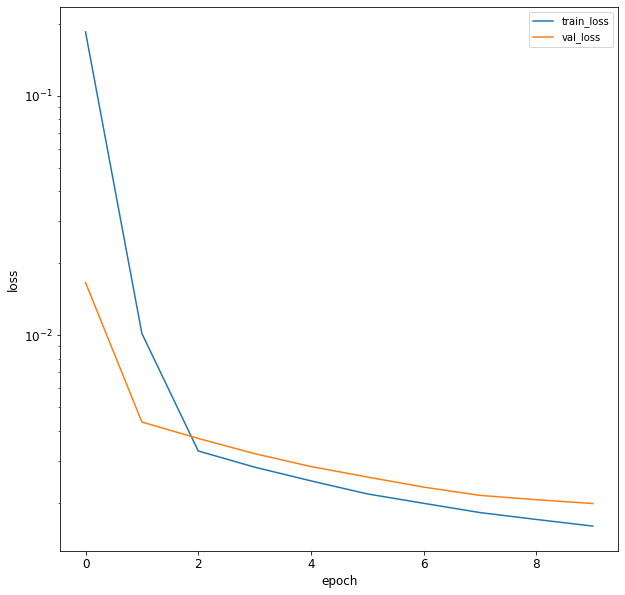

In [21]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

# **Evaluate the model**

**Load test data set**

In [22]:
df_test = pd.read_csv(url11)
df_test=pd.DataFrame(df_test)

In [23]:
df_test=df_test.drop(0)
df_test=df_test.head(200)

In [24]:
col_1=(df_test.columns)[0]
col_2=(df_test.columns)[1]
feature = 'Active Power'
df_test.rename(columns={col_1 :'Date & Time' , col_2 : feature},inplace=True)

In [25]:
col_3=(df_test.columns)[2]
df_test.rename(columns={col_3 :'Forecasted power'},inplace=True)

In [26]:
df_test=df_test.set_index('Date & Time')
df_test = df_test.apply(pd.to_numeric)
df_test=df_test.div(1000)

In [27]:
df_test

,Active Power,Forecasted power,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
Date & Time,,,,,,,,,,,,,,,,,,,
9/1/2021 0:00,93.79,101.37,101.45,101.52,101.59,101.67,101.75,101.81,101.89,101.98,102.07,102.15,102.21,102.29,102.36,102.43,102.50,102.56,102.64
9/1/2021 0:10,95.27,96.33,96.62,96.88,97.11,97.34,97.56,97.80,98.06,98.30,98.57,98.85,99.13,99.38,99.61,99.85,100.10,100.32,100.55
9/1/2021 0:20,96.55,96.62,96.88,97.11,97.34,97.56,97.80,98.06,98.30,98.57,98.85,99.13,99.38,99.61,99.85,100.10,100.32,100.55,100.77
9/1/2021 0:30,97.88,96.88,97.11,97.34,97.56,97.80,98.06,98.30,98.57,98.85,99.13,99.38,99.61,99.85,100.10,100.32,100.55,100.77,101.01
9/1/2021 0:40,97.87,96.43,96.67,96.92,97.14,97.39,97.67,97.90,98.18,98.47,98.79,99.06,99.29,99.55,99.82,100.05,100.30,100.51,100.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9/2/2021 8:30,41.44,18.04,16.92,15.84,14.78,13.71,12.63,11.56,12.27,12.99,13.69,14.43,15.18,15.93,16.12,16.32,16.52,16.71,16.91
9/2/2021 8:40,40.85,16.92,15.84,14.78,13.71,12.63,11.56,12.27,12.99,13.69,14.43,15.18,15.93,16.12,16.32,16.52,16.71,16.91,17.11
9/2/2021 8:50,40.25,15.84,14.78,13.71,12.63,11.56,12.27,12.99,13.69,14.43,15.18,15.93,16.12,16.32,16.52,16.71,16.91,17.11,17.25


In [28]:
scaler = MinMaxScaler()
test=pd.DataFrame(df_test[feature])
test[feature] = scaler.fit_transform(test)
test


,Active Power
Date & Time,
9/1/2021 0:00,0.91
9/1/2021 0:10,0.93
9/1/2021 0:20,0.94
9/1/2021 0:30,0.96
9/1/2021 0:40,0.96
...,...
9/2/2021 8:30,0.33
9/2/2021 8:40,0.32
9/2/2021 8:50,0.32


In [29]:
test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted[feature].shift(-1)

for t in range(1, T+1):
    test_shifted['active_power_t-'+str(T-t)] = test_shifted[feature].shift(T-t)
test_shifted = test_shifted.rename(columns={feature:'Original_active_power'})

forecasted_values=np.array(df_test['Forecasted power'])
test_shifted['Forecasted power'] = forecasted_values
test_shifted

,Original_active_power,y_t+1,active_power_t-5,active_power_t-4,active_power_t-3,active_power_t-2,active_power_t-1,active_power_t-0,Forecasted power
Date & Time,,,,,,,,,
9/1/2021 0:00,0.91,0.93,NaN,NaN,NaN,NaN,NaN,0.91,101.37
9/1/2021 0:10,0.93,0.94,NaN,NaN,NaN,NaN,0.91,0.93,96.33
9/1/2021 0:20,0.94,0.96,NaN,NaN,NaN,0.91,0.93,0.94,96.62
9/1/2021 0:30,0.96,0.96,NaN,NaN,0.91,0.93,0.94,0.96,96.88
9/1/2021 0:40,0.96,0.96,NaN,0.91,0.93,0.94,0.96,0.96,96.43
...,...,...,...,...,...,...,...,...,...
9/2/2021 8:30,0.33,0.32,0.41,0.41,0.39,0.34,0.32,0.33,18.04
9/2/2021 8:40,0.32,0.32,0.41,0.39,0.34,0.32,0.33,0.32,16.92
9/2/2021 8:50,0.32,0.31,0.39,0.34,0.32,0.33,0.32,0.32,15.84


In [30]:
test_shifted = test_shifted.dropna(how='any')
y_test = np.array(test_shifted['Original_active_power'])
X_test=np.array(test_shifted[['active_power_t-'+str(T-t) for t in range(1, T+1)]])
X_test = X_test.reshape(X_test.shape[0], T, 1)
X_test

array([[[0.91],
        [0.93],
        [0.94],
        [0.96],
        [0.96],
        [0.96]],

       [[0.93],
        [0.94],
        [0.96],
        [0.96],
        [0.96],
        [0.96]],

       [[0.94],
        [0.96],
        [0.96],
        [0.96],
        [0.96],
        [0.96]],

       ...,

       [[0.41],
        [0.39],
        [0.34],
        [0.32],
        [0.33],
        [0.32]],

       [[0.39],
        [0.34],
        [0.32],
        [0.33],
        [0.32],
        [0.32]],

       [[0.34],
        [0.32],
        [0.33],
        [0.32],
        [0.32],
        [0.31]]])

In [31]:
print(y_test.shape)
print(X_test.shape)

(194,)
(194, 6, 1)


In [32]:
predictions = model.predict(X_test)
predictions=pd.DataFrame(predictions)
predictions

,0
0,0.94
1,0.94
2,0.94
3,0.95
4,0.95
...,...
189,0.33
190,0.33
191,0.32
192,0.32


In [35]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['Date & Time'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='Date & Time', value_name='prediction', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df['prediction'] =predictions 

eval_df['Forecasted power']=np.array(test_shifted['Forecasted power'])
eval_df

,Date & Time,h,prediction,actual,Forecasted power
0,9/1/2021 0:50,t+1,0.94,0.96,96.80
1,9/1/2021 1:00,t+1,0.94,0.96,97.68
2,9/1/2021 1:10,t+1,0.94,0.96,99.21
3,9/1/2021 1:20,t+1,0.95,0.96,99.37
4,9/1/2021 1:30,t+1,0.95,0.96,99.40
...,...,...,...,...,...
189,9/2/2021 8:20,t+1,0.33,0.32,19.14
190,9/2/2021 8:30,t+1,0.33,0.33,18.04
191,9/2/2021 8:40,t+1,0.32,0.32,16.92
192,9/2/2021 8:50,t+1,0.32,0.32,15.84


In [36]:
eval_df[['prediction']]=scaler.inverse_transform(np.array(eval_df[['prediction']]))
eval_df[['actual']]=scaler.inverse_transform(np.array(eval_df[['actual']]))
eval_df

,Date & Time,h,prediction,actual,Forecasted power
0,9/1/2021 0:50,t+1,96.54,97.92,96.80
1,9/1/2021 1:00,t+1,96.63,98.02,97.68
2,9/1/2021 1:10,t+1,96.73,98.12,99.21
3,9/1/2021 1:20,t+1,96.75,98.13,99.37
4,9/1/2021 1:30,t+1,96.91,98.35,99.40
...,...,...,...,...,...
189,9/2/2021 8:20,t+1,41.30,40.83,19.14
190,9/2/2021 8:30,t+1,41.23,41.44,18.04
191,9/2/2021 8:40,t+1,40.89,40.85,16.92
192,9/2/2021 8:50,t+1,40.31,40.25,15.84


In [37]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

actual = eval_df['actual']
pred = eval_df['prediction']

mape(actual, pred)

1.9608574926514786

In [38]:
def rmse(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    x=np.mean((actual - pred)**2)
    return np.sqrt(x)

actual = eval_df['actual']
pred = eval_df['prediction']

rmse(actual, pred)

1.5777833478382657

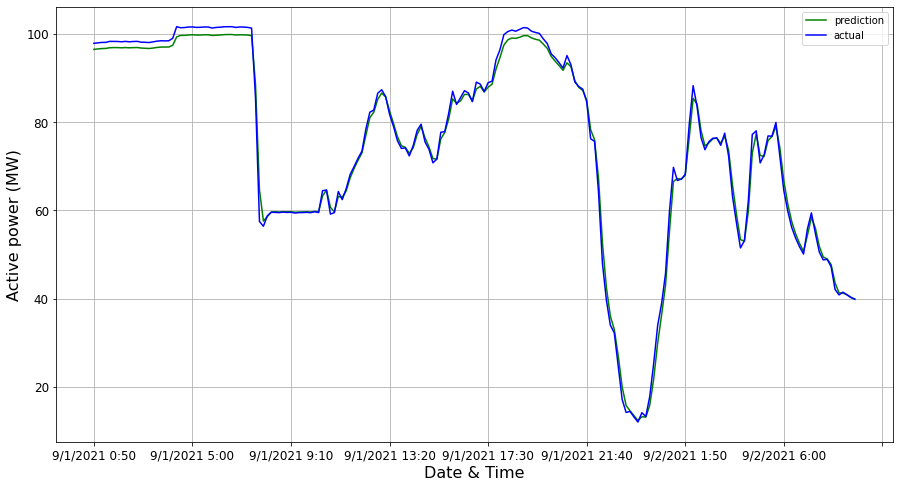

In [39]:
eval_df.plot(x='Date & Time', y=['prediction','actual'], style=['g','b'],fontsize=12, figsize=(15, 8))
plt.xlabel('Date & Time', fontsize=16)
plt.ylabel('Active power (MW)', fontsize=16)
plt.grid()
plt.show()

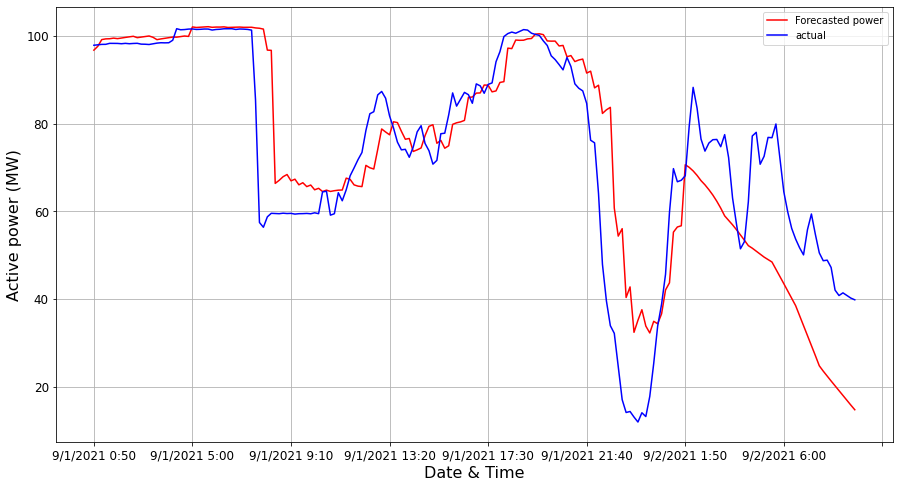

In [40]:
eval_df.plot(x='Date & Time', y=['Forecasted power', 'actual'], style=['r', 'b'],fontsize=12, figsize=(15, 8))
plt.xlabel('Date & Time', fontsize=16)
plt.ylabel('Active power (MW)', fontsize=16)
plt.grid()
plt.show()